In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 820M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.
C:\Users\Shikhar\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [91]:
#path = "data/ml-20m/"
path = "data/ml-1m/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

In [92]:
ratings = pd.read_csv(path+'ratings.csv')
len(ratings)

1000209

In [93]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()
users, movies

(array([   1,    2,    3, ..., 6038, 6039, 6040], dtype=int64),
 array([1193,  661,  914, ..., 2845, 3607, 2909], dtype=int64))

In [94]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [95]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])


In [96]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(6040, 3706)

In [97]:
n_factors = 50

In [98]:
np.random.seed = 42

In [99]:
msk = np.random.rand(len(ratings)) < 0.8
print (msk)
trn = ratings[msk]
val = ratings[~msk]


[ True  True  True ...  True  True False]


In [100]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [101]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)


In [102]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [104]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [105]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [106]:
train_history = nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 799864 samples, validate on 200345 samples
Epoch 1/10
799864/799864 [==============================] - 220s - loss: 1.3056 - val_loss: 0.9331: 1.30
Epoch 2/10
799864/799864 [==============================] - 216s - loss: 0.9687 - val_loss: 0.9215
Epoch 3/10
799864/799864 [==============================] - 234s - loss: 0.9633 - val_loss: 0.9181- los
Epoch 4/10
799864/799864 [==============================] - 233s - loss: 0.9616 - val_loss: 0.9130
Epoch 5/10
799864/799864 [==============================] - 225s - loss: 0.9598 - val_loss: 0.91010s - lo
Epoch 6/10
799864/799864 [==============================] - 235s - loss: 0.9573 - val_loss: 0.9071 - ETA: 3 - -
Epoch 7/10
799864/799864 [==============================] - 236s - loss: 0.9576 - val_loss: 0.9136: 0.957 - ETA: 2s  -
Epoch 8/10
799864/799864 [==============================] - 229s - loss: 0.9576 - val_loss: 0.9068
Epoch 9/10
799864/799864 [==============================] - 226s - loss: 0.9564 - val_loss: 0.9093
Epoch 

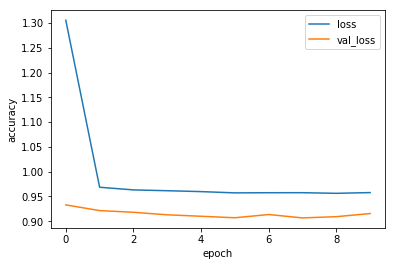

In [107]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [108]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.35)(x)
x = Dense(500,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10,activation='relu')(x)
x = Dense(1,activation='relu')(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [109]:
train_history = nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 799864 samples, validate on 200345 samples
Epoch 1/10
799864/799864 [==============================] - 263s - loss: 1.0196 - val_loss: 0.9261
Epoch 2/10
799864/799864 [==============================] - 256s - loss: 0.9463 - val_loss: 0.9421
Epoch 3/10
799864/799864 [==============================] - 269s - loss: 0.9452 - val_loss: 0.9220
Epoch 4/10
799864/799864 [==============================] - 271s - loss: 0.9443 - val_loss: 0.9144
Epoch 5/10
799864/799864 [==============================] - 270s - loss: 0.9432 - val_loss: 0.9177
Epoch 6/10
799864/799864 [==============================] - 260s - loss: 0.9442 - val_loss: 0.9149
Epoch 7/10
799864/799864 [==============================] - 268s - loss: 0.9436 - val_loss: 0.9207
Epoch 8/10
799864/799864 [==============================] - 266s - loss: 0.9430 - val_loss: 0.9142
Epoch 9/10
799864/799864 [==============================] - 258s - loss: 0.9448 - val_loss: 0.9162
Epoch 10/10
799864/799864 [==============================

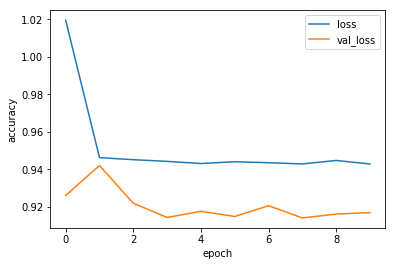

In [110]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [115]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5,activation='relu')(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [116]:
train_history = nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=128, nb_epoch=30, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 799864 samples, validate on 200345 samples
Epoch 1/30
799864/799864 [==============================] - 117s - loss: 1.1048 - val_loss: 0.8505: 1.104
Epoch 2/30
799864/799864 [==============================] - 117s - loss: 0.8543 - val_loss: 0.8403: 0. - E - ETA: 0s - loss: 0.85
Epoch 3/30
799864/799864 [==============================] - 112s - loss: 0.8412 - val_loss: 0.8329
Epoch 4/30
799864/799864 [==============================] - 118s - loss: 0.8361 - val_loss: 0.8321: 0.8 - ETA: 4s -  - ETA: 1s - l - ETA: 0s - los
Epoch 5/30
799864/799864 [==============================] - 118s - loss: 0.8338 - val_loss: 0.8320
Epoch 6/30
799864/799864 [==============================] - 113s - loss: 0.8324 - val_loss: 0.8310
Epoch 7/30
799864/799864 [==============================] - 117s - loss: 0.8318 - val_loss: 0.8307s - loss: 0 - ETA: 1s - los - ETA
Epoch 8/30
799864/799864 [==============================] - 117s - loss: 0.8295 - val_loss: 0.8314
Epoch 9/30
799864/799864 [===========

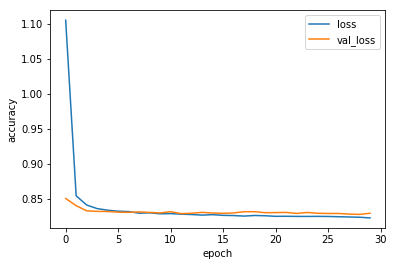

In [120]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [121]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5,activation='relu')(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [122]:
train_history = nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 799864 samples, validate on 200345 samples
Epoch 1/10
799864/799864 [==============================] - 191s - loss: 0.9887 - val_loss: 0.8560
Epoch 2/10
799864/799864 [==============================] - 234s - loss: 0.8655 - val_loss: 0.8510
Epoch 3/10
799864/799864 [==============================] - 232s - loss: 0.8578 - val_loss: 0.8522
Epoch 4/10
799864/799864 [==============================] - 224s - loss: 0.8545 - val_loss: 0.8486
Epoch 5/10
799864/799864 [==============================] - 212s - loss: 0.8532 - val_loss: 0.8518
Epoch 6/10
799864/799864 [==============================] - 220s - loss: 0.8518 - val_loss: 0.8467
Epoch 7/10
799864/799864 [==============================] - 220s - loss: 0.8511 - val_loss: 0.8624
Epoch 8/10
799864/799864 [==============================] - 233s - loss: 0.8507 - val_loss: 0.8461
Epoch 9/10
799864/799864 [==============================] - 221s - loss: 0.8499 - val_loss: 0.8482
Epoch 10/10
799864/799864 [==============================

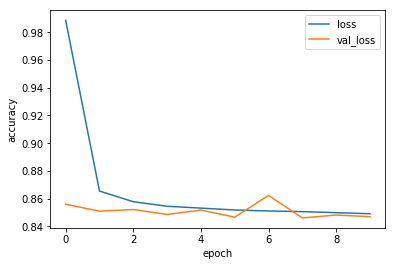

In [124]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()